In [5]:
# Import library
import pyspark
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [6]:
# Create a SparkSession
spark = SparkSession.builder.appName("BikeStore").getOrCreate()

# Load dataset
df_brand = spark.read.load("/content/brands.csv",format="csv", sep=",", inferSchema="true", header="true")
df_category = spark.read.load("/content/categories.csv",format="csv", sep=",", inferSchema="true", header="true")
df_customer = spark.read.load("/content/customers.csv",format="csv", sep=",", inferSchema="true", header="true")
df_order_item = spark.read.load("/content/order_items.csv",format="csv", sep=",", inferSchema="true", header="true")
df_order = spark.read.load("/content/orders.csv",format="csv", sep=",", inferSchema="true", header="true")
df_product = spark.read.load("/content/products.csv",format="csv", sep=",", inferSchema="true", header="true")
df_staff = spark.read.load("/content/staffs.csv",format="csv", sep=",", inferSchema="true", header="true")
df_stock = spark.read.load("/content/stocks.csv",format="csv", sep=",", inferSchema="true", header="true")
df_store = spark.read.load("/content/stores.csv",format="csv", sep=",", inferSchema="true", header="true")
df_brand.show(10)
df_category.show(10)
df_customer.show(10)
df_order_item.show(10)
df_order.show(10)
df_product.show(10)
df_staff.show(10)
df_stock.show(10)
df_store.show(10)

+--------+------------+
|brand_id|  brand_name|
+--------+------------+
|       1|     Electra|
|       2|        Haro|
|       3|      Heller|
|       4| Pure Cycles|
|       5|     Ritchey|
|       6|     Strider|
|       7|Sun Bicycles|
|       8|       Surly|
|       9|        Trek|
+--------+------------+

+-----------+-------------------+
|category_id|      category_name|
+-----------+-------------------+
|          1|  Children Bicycles|
|          2|   Comfort Bicycles|
|          3|  Cruisers Bicycles|
|          4|Cyclocross Bicycles|
|          5|     Electric Bikes|
|          6|     Mountain Bikes|
|          7|         Road Bikes|
+-----------+-------------------+

+-----------+----------+---------+--------------+--------------------+--------------------+---------------+-----+--------+
|customer_id|first_name|last_name|         phone|               email|              street|           city|state|zip_code|
+-----------+----------+---------+--------------+-----------------

In [7]:
# Create database table
df_brand.createOrReplaceTempView("brand")
df_category.createOrReplaceTempView("category")
df_customer.createOrReplaceTempView("customer")
df_order_item.createOrReplaceTempView("order_item")
df_order.createOrReplaceTempView("order")
df_product.createOrReplaceTempView("product")
df_staff.createOrReplaceTempView("staff")
df_stock.createOrReplaceTempView("stock")
df_store.createOrReplaceTempView("store")

+----------------+-------------------+--------------+
|           Store|   Product Category|Total Customer|
+----------------+-------------------+--------------+
|   Baldwin Bikes|  Cruisers Bicycles|           625|
|   Baldwin Bikes|     Mountain Bikes|           559|
|   Baldwin Bikes|  Children Bicycles|           422|
|   Baldwin Bikes|   Comfort Bicycles|           316|
|   Baldwin Bikes|         Road Bikes|           201|
|Santa Cruz Bikes|  Cruisers Bicycles|           176|
|Santa Cruz Bikes|     Mountain Bikes|           173|
|   Baldwin Bikes|Cyclocross Bicycles|           168|
|Santa Cruz Bikes|  Children Bicycles|           125|
|   Baldwin Bikes|     Electric Bikes|           120|
|   Rowlett Bikes|  Cruisers Bicycles|            98|
|Santa Cruz Bikes|   Comfort Bicycles|            97|
|   Rowlett Bikes|     Mountain Bikes|            78|
|   Rowlett Bikes|  Children Bicycles|            63|
|Santa Cruz Bikes|         Road Bikes|            62|
|Santa Cruz Bikes|Cyclocross

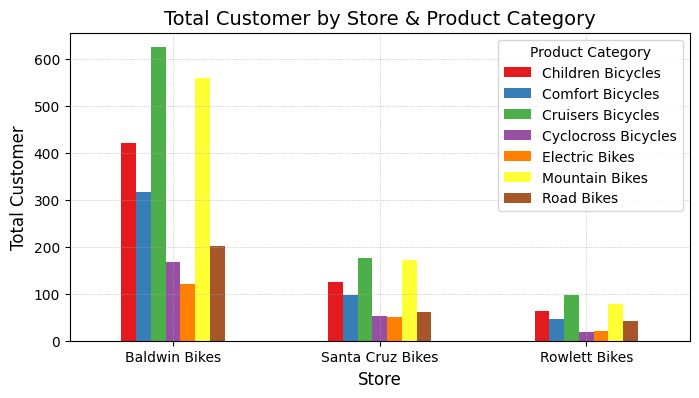

In [12]:
# How many total customer by store & product category
total_customer_store_category = spark.sql("""
  SELECT
    se.store_name AS Store,
    cy.category_name AS `Product Category`,
    COUNT(DISTINCT or.customer_id) AS `Total Customer`
  FROM store se
  LEFT JOIN order or ON se.store_id = or.store_id
  LEFT JOIN order_item om ON or.order_id = om.order_id
  LEFT JOIN product pt ON om.product_id = pt.product_id
  LEFT JOIN category cy ON pt.category_id = cy.category_id
  GROUP BY se.store_name, cy.category_name
  ORDER BY `Total Customer` DESC;
""")
# Display the result
total_customer_store_category.show()

# Convert Spark DataFrame to Pandas DataFrame
total_customer_store_category_pd = total_customer_store_category.toPandas()

# Pivot the DataFrame to reorganize data by store and product category
total_customer_store_category_pivot = total_customer_store_category_pd.pivot_table(
    index='Store',
    columns='Product Category',
    values='Total Customer',
    aggfunc='sum'
)

# Add a column for total customer and sort by it in descending order
total_customer_store_category_pivot['Total Customer'] = total_customer_store_category_pivot.sum(axis=1)
total_customer_store_category_pivot = total_customer_store_category_pivot.sort_values('Total Customer', ascending=False)

# Plot the data
color_palette = plt.cm.Set1([i / len(total_customer_store_category_pivot.columns)
                             for i in range(len(total_customer_store_category_pivot.columns))])

total_customer_store_category_pivot.drop('Total Customer', axis=1).plot(
    kind='bar',
    stacked=False,
    color=color_palette,
    figsize=(8, 4)
)

# Add plot details
plt.title('Total Customer by Store & Product Category', fontsize=14)
plt.ylabel('Total Customer', fontsize=12)
plt.xlabel('Store', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Product Category')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+------------+-------------------+--------------+
|       Brand|   Product Category|Total Customer|
+------------+-------------------+--------------+
|     Electra|  Cruisers Bicycles|           661|
|        Trek|     Mountain Bikes|           446|
|     Electra|  Children Bicycles|           423|
|       Surly|     Mountain Bikes|           316|
|     Electra|   Comfort Bicycles|           314|
|        Trek|         Road Bikes|           264|
| Pure Cycles|  Cruisers Bicycles|           231|
|Sun Bicycles|  Cruisers Bicycles|           214|
|       Surly|Cyclocross Bicycles|           186|
|Sun Bicycles|   Comfort Bicycles|           177|
|        Trek|     Electric Bikes|           165|
|        Trek|  Children Bicycles|           158|
|        Haro|     Mountain Bikes|           120|
|      Heller|     Mountain Bikes|            97|
|        Haro|  Children Bicycles|            82|
|     Ritchey|     Mountain Bikes|            77|
|        Trek|Cyclocross Bicycles|            58|


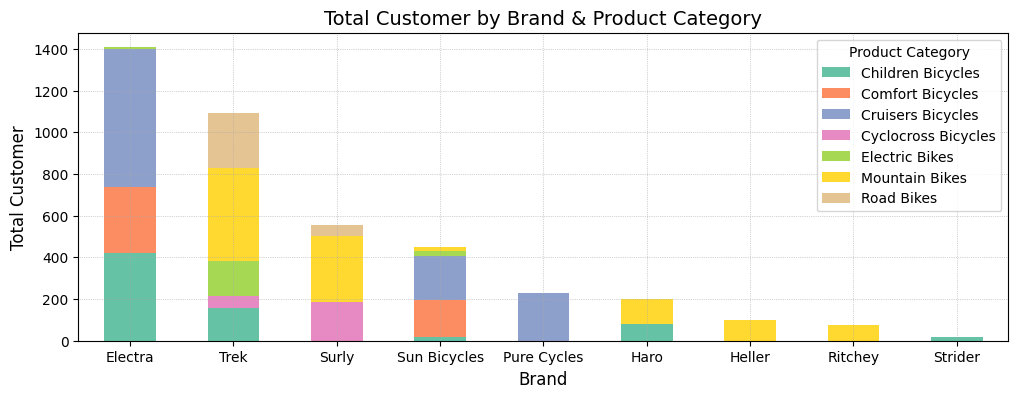

In [20]:
# How many total customer by brand & product category
total_customer_brand_category = spark.sql("""
  SELECT
    bd.brand_name AS Brand,
    cy.category_name AS `Product Category`,
    COUNT(DISTINCT or.customer_id) AS `Total Customer`
  FROM brand bd
  LEFT JOIN product pt ON bd.brand_id = pt.brand_id
  LEFT JOIN category cy ON pt.category_id = cy.category_id
  LEFT JOIN order_item om ON pt.product_id = om.product_id
  LEFT JOIN order or ON om.order_id = or.order_id
  GROUP BY bd.brand_name, cy.category_name
  ORDER BY `Total Customer` DESC;
""")
# Display the result
total_customer_brand_category.show()

# Convert Spark DataFrame to Pandas DataFrame
total_customer_brand_category_pd = total_customer_brand_category.toPandas()

# Pivot the DataFrame to reorganize data by brand and product category
total_customer_brand_category_pivot = total_customer_brand_category_pd.pivot_table(
    index='Brand',
    columns='Product Category',
    values='Total Customer',
    aggfunc='sum'
)

# Add a column for total customer and sort by it in descending order
total_customer_brand_category_pivot['Total Customer'] = total_customer_brand_category_pivot.sum(axis=1)
total_customer_brand_category_pivot = total_customer_brand_category_pivot.sort_values('Total Customer', ascending=False)

# Plot the data
color_palette = plt.cm.Set2([i / len(total_customer_brand_category_pivot.columns)
                             for i in range(len(total_customer_brand_category_pivot.columns))])

total_customer_brand_category_pivot.drop('Total Customer', axis=1).plot(
    kind='bar',
    stacked=True,
    color=color_palette,
    figsize=(12, 4)
)

# Add plot details
plt.title('Total Customer by Brand & Product Category', fontsize=14)
plt.ylabel('Total Customer', fontsize=12)
plt.xlabel('Brand', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Product Category')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+------------+----------------+--------------+
|       Brand|           Store|Total Customer|
+------------+----------------+--------------+
|     Electra|   Baldwin Bikes|           709|
|        Trek|   Baldwin Bikes|           552|
|       Surly|   Baldwin Bikes|           349|
|Sun Bicycles|   Baldwin Bikes|           264|
|     Electra|Santa Cruz Bikes|           204|
|        Trek|Santa Cruz Bikes|           174|
| Pure Cycles|   Baldwin Bikes|           163|
|        Haro|   Baldwin Bikes|           134|
|       Surly|Santa Cruz Bikes|           110|
|     Electra|   Rowlett Bikes|           103|
|        Trek|   Rowlett Bikes|            85|
|Sun Bicycles|Santa Cruz Bikes|            71|
|      Heller|   Baldwin Bikes|            71|
|       Surly|   Rowlett Bikes|            52|
|Sun Bicycles|   Rowlett Bikes|            50|
|     Ritchey|   Baldwin Bikes|            49|
| Pure Cycles|Santa Cruz Bikes|            40|
|        Haro|Santa Cruz Bikes|            36|
| Pure Cycles

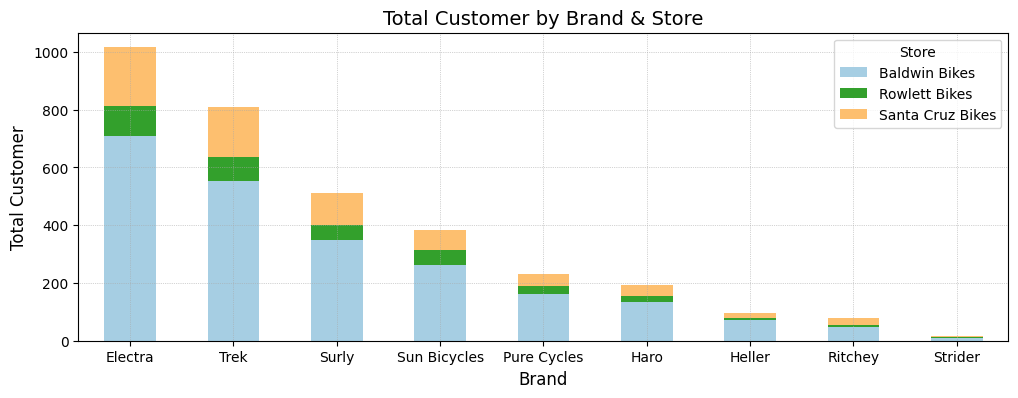

In [23]:
# How many total customer by brand & store
total_customer_brand_store = spark.sql("""
  SELECT
    bd.brand_name AS Brand,
    se.store_name AS Store,
    COUNT(DISTINCT or.customer_id) AS `Total Customer`
  FROM brand bd
  LEFT JOIN product pt ON bd.brand_id = pt.brand_id
  LEFT JOIN order_item om ON pt.product_id = om.product_id
  LEFT JOIN order or ON om.order_id = or.order_id
  LEFT JOIN store se ON or.store_id = se.store_id
  GROUP BY bd.brand_name, se.store_name
  ORDER BY `Total Customer` DESC;
""")
# Display the result
total_customer_brand_store.show()

# Convert Spark DataFrame to Pandas DataFrame
total_customer_brand_store_pd = total_customer_brand_store.toPandas()

# Pivot the DataFrame to reorganize data by brand and store
total_customer_brand_store_pivot = total_customer_brand_store_pd.pivot_table(
    index='Brand',
    columns='Store',
    values='Total Customer',
    aggfunc='sum'
)

# Add a column for total customer and sort by it in descending order
total_customer_brand_store_pivot['Total Customer'] = total_customer_brand_store_pivot.sum(axis=1)
total_customer_brand_store_pivot = total_customer_brand_store_pivot.sort_values('Total Customer', ascending=False)

# Plot the data
color_palette = plt.cm.Paired([i / len(total_customer_brand_store_pivot.columns)
                             for i in range(len(total_customer_brand_store_pivot.columns))])

total_customer_brand_store_pivot.drop('Total Customer', axis=1).plot(
    kind='bar',
    stacked=True,
    color=color_palette,
    figsize=(12, 4)
)

# Add plot details
plt.title('Total Customer by Brand & Store', fontsize=14)
plt.ylabel('Total Customer', fontsize=12)
plt.xlabel('Brand', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Store')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+----------------+--------------+
|           Store|Total Customer|
+----------------+--------------+
|   Baldwin Bikes|          1019|
|Santa Cruz Bikes|           284|
|   Rowlett Bikes|           142|
+----------------+--------------+



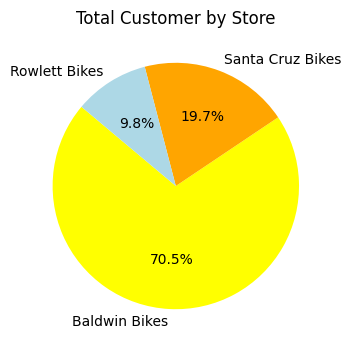

In [27]:
# How many total customer by order year & store
total_customer_store = spark.sql("""
  SELECT
    se.store_name AS Store,
    COUNT(DISTINCT customer_id) AS `Total Customer`
  FROM order or
  LEFT JOIN store se ON or.store_id = se.store_id
  GROUP BY se.store_name
  ORDER BY `Total Customer` DESC;
""")
# Display the result
total_customer_store.show()

# Convert Spark DataFrame to Pandas DataFrame
total_customer_store_pd = total_customer_store.toPandas()

# Plotting the pie chart
plt.figure(figsize=(5, 4))
plt.pie(
    total_customer_store_pd['Total Customer'],
    labels=total_customer_store_pd['Store'],
    autopct='%1.1f%%',
    colors=['yellow', 'orange', 'lightblue'],  # Add more colors if necessary
    startangle=140
)
plt.title('Total Customer by Store')
plt.show()